In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import random

import numpy as np
import pandas as pd
import xgboost as xgb
from FRUFS import FRUFS
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

SEED = 721991

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)    
    tf.random.set_seed(seed)

In [2]:
# Reading the data
df_train = pd.read_csv('./train_features.csv')
df_test = pd.read_csv('./test_features.csv')
df_train_targets_scored = pd.read_csv('./train_targets_scored.csv')
df_train_targets_nonscored = pd.read_csv('./train_targets_nonscored.csv')
df_test_targets = pd.read_csv('./sample_submission.csv')

# Identifying target features
target_features_scored = list(df_train_targets_scored.columns[1:])
target_features_nonscored = list(df_train_targets_nonscored.columns[1:])

# Identifying columns to retain that have at least 2 non-zero entries
columns_to_retain_nonscored = [col for col in df_train_targets_nonscored.columns if (df_train_targets_nonscored[col] != 0).sum() >= 8]

# Selecting only the retained columns
df_train_targets_nonscored = df_train_targets_nonscored[columns_to_retain_nonscored]

# Updating the list of target features for nonscored targets
target_features_nonscored = [col for col in columns_to_retain_nonscored if col != 'sig_id']  # Assuming 'sig_id' is not a target feature

# Type conversion for optimization
df_train_targets_scored[target_features_scored] = df_train_targets_scored[target_features_scored].astype(np.uint8)
df_train_targets_nonscored[target_features_nonscored] = df_train_targets_nonscored[target_features_nonscored].astype(np.uint8)
df_test_targets[target_features_scored] = df_test_targets[target_features_scored].astype(np.float32)


In [3]:
df_train = df_train.merge(df_train_targets_scored, on='sig_id', how='left')
df_train = df_train.merge(df_train_targets_nonscored, on='sig_id', how='left')
df_test = df_test.merge(df_test_targets, on='sig_id', how='left')

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape = (23814, 1276)
Training Set Memory Usage = 168.24 MB
Test Set Shape = (3982, 1082)
Test Set Memory Usage = 29.74 MB


In [4]:
df_train.head()
# sig_id is the unique sample id
# Features with g- prefix are gene expression features and there are 772 of them (from g-0 to g-771)
# Features with c- prefix are cell viability features and there are 100 of them (from c-0 to c-99)
# cp_type is a binary categorical feature which indicates the samples are treated with a compound or with a control perturbation (trt_cp or ctl_vehicle)
# cp_time is a categorical feature which indicates the treatment duration (24, 48 or 72 hours)
# cp_dose is a binary categorical feature which indicates the dose is low or high (D1 or D2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,...,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,abl_inhibitor,ace_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldose_reductase_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antithyroid_agent,antitussive,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,axl_kinase_inhibitor,bacterial_protein_synthesis_inhibitor,beta_catenin_inhibitor,beta_lactamase_inhibitor,beta_secretase_inhibitor,big1_inhibitor,bone_resorption_inhibitor,bradykinin_receptor_antagonist,breast_cancer_resistance_protein_inhibitor,calcitonin_antagonist,calcium_channel_activator,calmodulin_inhibitor,camp_stimulant,capillary_stabilizing_agent,car_antagonist,carcinogen,caspase_inhibitor,cathepsin_inhibitor,cdc_inhibitor,cell_cycle_inhibitor,cftr_channel_agonist,chloride_channel_activator,choleretic_agent,cholinergic_receptor_agonist,cholinesterase_inhibitor,coenzyme_a_precursor,contraceptive_agent,cyclin_d_inhibitor,cytokine_production_inhibitor,dehydrogenase_inhibitor,diacylglycerol_kinase_inhibitor,diacylglycerol_o_acyltransferase_inhibitor,dihydroorotate_dehydrogenase_inhibitor,dihydropteroate_synthase_inhibitor,dna_dependent_protein_kinase_inhibitor,dot1l_inhibitor,dynamin_inhibitor,dyrk_inhibitor,endothelin_receptor_antagonist,eukaryotic_tr

In [5]:
g_features = [feature for feature in df_train.columns if feature.startswith('g-')]
c_features = [feature for feature in df_train.columns if feature.startswith('c-')]
other_features = [feature for feature in df_train.columns if feature not in g_features and 
                                                             feature not in c_features and 
                                                             feature not in target_features_scored and
                                                             feature not in target_features_nonscored]

print(f'Number of g- Features: {len(g_features)}')
print(f'Number of c- Features: {len(c_features)}')
print(f'Number of Other Features: {len(other_features)} ({other_features})')

Number of g- Features: 772
Number of c- Features: 100
Number of Other Features: 4 (['sig_id', 'cp_type', 'cp_time', 'cp_dose'])


In [6]:
# check for any NA Values
df_train.isna().sum().sum()

0

## Dataset Operations

In [7]:
df_train

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,...,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,abl_inhibitor,ace_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldose_reductase_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antithyroid_agent,antitussive,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,axl_kinase_inhibitor,bacterial_protein_synthesis_inhibitor,beta_catenin_inhibitor,beta_lactamase_inhibitor,beta_secretase_inhibitor,big1_inhibitor,bone_resorption_inhibitor,bradykinin_receptor_antagonist,breast_cancer_resistance_protein_inhibitor,calcitonin_antagonist,calcium_channel_activator,calmodulin_inhibitor,camp_stimulant,capillary_stabilizing_agent,car_antagonist,carcinogen,caspase_inhibitor,cathepsin_inhibitor,cdc_inhibitor,cell_cycle_inhibitor,cftr_channel_agonist,chloride_channel_activator,choleretic_agent,cholinergic_receptor_agonist,cholinesterase_inhibitor,coenzyme_a_precursor,contraceptive_agent,cyclin_d_inhibitor,cytokine_production_inhibitor,dehydrogenase_inhibitor,diacylglycerol_kinase_inhibitor,diacylglycerol_o_acyltransferase_inhibitor,dihydroorotate_dehydrogenase_inhibitor,dihydropteroate_synthase_inhibitor,dna_dependent_protein_kinase_inhibitor,dot1l_inhibitor,dynamin_inhibitor,dyrk_inhibitor,endothelin_receptor_antagonist,eukaryotic_tr

In [8]:
# # # PCA karo?
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# c_features = [feature for feature in df_train.columns if feature.startswith('c-')]
# g_features = [feature for feature in df_train.columns if feature.startswith('g-')]
# selected_g_features = ['g-37', 'g-50', 'g-672', 'g-489', 'g-349', 'g-460', 'g-569', 'g-369', 'g-123', 'g-744', 'g-195', 'g-63', 'g-121', 'g-410', 'g-248', 'g-228', 'g-38', 'g-72', 'g-760', 'g-261', 'g-417', 'g-328', 'g-406', 'g-257']


# scaler = StandardScaler()
# c_features_scaled = scaler.fit_transform(df_train[c_features])
# g_features_scaled = scaler.fit_transform(df_train[selected_g_features])

# pca = PCA(n_components=5)
# c_features_pca = pca.fit_transform(c_features_scaled)
# g_features_pca = pca.fit_transform(g_features_scaled)

# # Drop original 'c' features
# df_train = df_train.drop(c_features, axis=1)
# # Create a DataFrame for the PCA components
# c_features_pca_df = pd.DataFrame(c_features_pca, columns=['c_pc1', 'c_pc2', 'c_pc3', 'c_pc4', 'c_pc5'])
# # Concatenate the PCA components with the original DataFrame
# df_train = pd.concat([df_train, c_features_pca_df], axis=1)
# #
# # # Drop original 'g' features
# df_train = df_train.drop(selected_g_features, axis=1)
# # Create a DataFrame for the PCA components
# g_features_pca_df = pd.DataFrame(g_features_pca, columns=['g_pc1', 'g_pc2', 'g_pc3', 'g_pc4', 'g_pc5'])
# # Concatenate the PCA components with the original DataFrame
# df_train = pd.concat([df_train, g_features_pca_df], axis=1)


# c_features = [feature for feature in df_train.columns if feature.startswith('c_pc')]
# g_features = [feature for feature in g_features if feature not in selected_g_features]
# g_features += ['g_pc1', 'g_pc2', 'g_pc3', 'g_pc4', 'g_pc5']

In [9]:
# Shuffle the dataset
df_train = shuffle(df_train, random_state=42)

# Drop the 'sig_id' column
df_train = df_train.drop('sig_id', axis=1)

# One-hot encoding for 'cp_type', 'cp_time', 'cp_dose'
one_hot_encoder = OneHotEncoder(sparse=False)
cp_time_encoder = LabelEncoder()
cp_dose_encoder = LabelEncoder()

encoded_columns = one_hot_encoder.fit_transform(df_train[['cp_type']])
column_names = one_hot_encoder.get_feature_names_out(['cp_type'])

df_train['cp_time'] = cp_time_encoder.fit_transform(df_train['cp_time'])
df_train['cp_dose'] = cp_dose_encoder.fit_transform(df_train['cp_dose'])

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=column_names)

c:\Users\chopr\anaconda3\envs\part-time\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
# Drop original columns and concat the new encoded columns
df_train = df_train.drop(['cp_type'], axis=1)
df_train = pd.concat([df_train, encoded_df], axis=1)

In [11]:
# Identify the one-hot encoded features for cp_type, cp_time, and cp_dose
one_hot_features = [feature for feature in df_train.columns if feature.startswith('cp_type_')]

# Combine all feature lists to create the X dataset
feature_columns = g_features + c_features + one_hot_features + ['cp_time', 'cp_dose']
X = df_train[feature_columns]

# For Y, use the columns that are not in the features list
Y = df_train.drop(feature_columns, axis=1)

print(f'Number of g- Features: {len(g_features)}')
print(f'Number of c- Features: {len(c_features)}')
print(f'Number of One Hot Features: {len(one_hot_features)} ({one_hot_features})')


Number of g- Features: 772
Number of c- Features: 100
Number of One Hot Features: 2 (['cp_type_ctl_vehicle', 'cp_type_trt_cp'])


In [12]:
# Check Data Consistency
# Features should add up
print((len(target_features_scored) + len(target_features_nonscored))==Y.shape[1])
# entire data should add up
print(df_train.shape[1] == (1484 - 4 + 7)) #(original shape, - 4 ( 3 categorical features + sig_id) + 7 )
# the difference in Y and entire dataset should just be the features 
print(df_train.shape[1] - Y.shape[1] == len(g_features)+len(c_features)+len(one_hot_features))

True
False
False


In [13]:
df_train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,...,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,abl_inhibitor,ace_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldose_reductase_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antithyroid_agent,antitussive,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,axl_kinase_inhibitor,bacterial_protein_synthesis_inhibitor,beta_catenin_inhibitor,beta_lactamase_inhibitor,beta_secretase_inhibitor,big1_inhibitor,bone_resorption_inhibitor,bradykinin_receptor_antagonist,breast_cancer_resistance_protein_inhibitor,calcitonin_antagonist,calcium_channel_activator,calmodulin_inhibitor,camp_stimulant,capillary_stabilizing_agent,car_antagonist,carcinogen,caspase_inhibitor,cathepsin_inhibitor,cdc_inhibitor,cell_cycle_inhibitor,cftr_channel_agonist,chloride_channel_activator,choleretic_agent,cholinergic_receptor_agonist,cholinesterase_inhibitor,coenzyme_a_precursor,contraceptive_agent,cyclin_d_inhibitor,cytokine_production_inhibitor,dehydrogenase_inhibitor,diacylglycerol_kinase_inhibitor,diacylglycerol_o_acyltransferase_inhibitor,dihydroorotate_dehydrogenase_inhibitor,dihydropteroate_synthase_inhibitor,dna_dependent_protein_kinase_inhibitor,dot1l_inhibitor,dynamin_inhibitor,dyrk_inhibitor,endothelin_receptor_antagonist,eukaryotic_translation_initiation_factor_inhibitor,exporti

## Basline ML model

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt


# Separate the DataFrame into continuous and one-hot encoded features
X_continuous = X[g_features + c_features+ ['cp_time', 'cp_dose']] 
X_one_hot = X[one_hot_features]

# Scale the continuous features
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous)

# Combine the scaled continuous features and one-hot encoded features
X_scaled = np.concatenate([X_continuous_scaled, X_one_hot], axis=1)

# Verify that X and X_scaled have the same dimensions
print(X_scaled.shape == X.shape)


True


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

n_features = Y.shape[1]
# split Y into train and test
Y_original_train, Y_original_test = train_test_split(Y, test_size=0.2, random_state=8)

# trying to reduce the output features using autoencoders
input_layer = Input(shape=(n_features,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)  # Encoded representation

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(n_features, activation='sigmoid')(decoded)  # Reconstruction
# autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# Compile
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
# Summary
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400)]             0         
                                                                 
 dense (Dense)               (None, 128)               51328     
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dense_3 (Dense)             (None, 400)               26000     
                                                                 
Total params: 80480 (314.38 KB)
Trainable params: 80480 (314.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
random.seed(1)
autoencoder.fit(Y_original_train, Y_original_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(Y_original_test, Y_original_test))

Epoch 1/50

75/75 [==============================] - 1s 7ms/step - loss: 0.3808 - val_loss: 0.0196
Epoch 2/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0176 - val_loss: 0.0164
Epoch 3/50
75/75 [==============================] - 0s 5ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 4/50
75/75 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0147
Epoch 5/50
75/75 [==============================] - 0s 5ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 6/50
75/75 [==============================] - 0s 5ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 7/50
75/75 [==============================] - 0s 5ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 8/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 9/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 10/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 11/50
75/75 

In [17]:
# X_scaled_np = X_scaled.values
# Y_np = Y.values
# Split data
# X_train, y_train, X_test, y_test = iterative_train_test_split(X_scaled, Y.to_numpy(), test_size=0.1)
# X_train, y_train, X_test, y_test = iterative_train_test_split(X_scaled, Y_encoded, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Example of checking the format of y_train
print(y_train.shape)  # Should be (n_samples, n_labels)

(19051, 400)


In [18]:
# encoder model
encoder = Model(inputs=input_layer, outputs=encoded)
# Get the 20-dimensional encoded representation
Y_encoded = encoder.predict(y_train)

596/596 [==============================] - 0s 670us/step


In [19]:
column_sums = Y_encoded.sum(axis=0)
print(column_sums)

[ 61590.04  115991.055 105720.92   70099.04   59290.023  98667.87
  84780.59   77219.8   127840.805  82766.47   74707.805 130363.41
  71735.8   135565.05  119667.805  91270.77 ]


In [74]:
params = {'estimator__colsample_bytree': 0.6522,
          'estimator__gamma': 3.6975,
          'estimator__learning_rate': 0.0503,
          'estimator__max_delta_step': 2.0706,
          'estimator__max_depth': 10,
          'estimator__min_child_weight': 31.5800,
          'estimator__n_estimators': 166,
          'estimator__subsample': 0.8639
         }


# Model
# model = MultiOutputClassifier(LogisticRegression()) # F1 Score = 0.25655
# # model = MultiOutputClassifier(LogisticRegression()) # F1 Score = 0.1456 (with PCA, on both c and g features)
# # model = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')) # F1 Score = 0.2747
# model = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')) # F1 Score = 0.1931 (both cells and genes PCA)
# model = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')) # F1 Score = 0.2622 (only cells PCA)
model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', eval_metric='logloss', tree_method="hist", device="cuda")) # F1 Score = 0.1697 (only cells PCA)
model.set_params(**params)
setattr(model, 'verbosity', 2)

model.fit(X_train, Y_encoded)

# Make predictions
y_pred = model.predict(X_test)

feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)
feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)
feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)
feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)
feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)
feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)
feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)
feature_importances shape: (876,)
estimator.feature_importances_ shape: (876,)


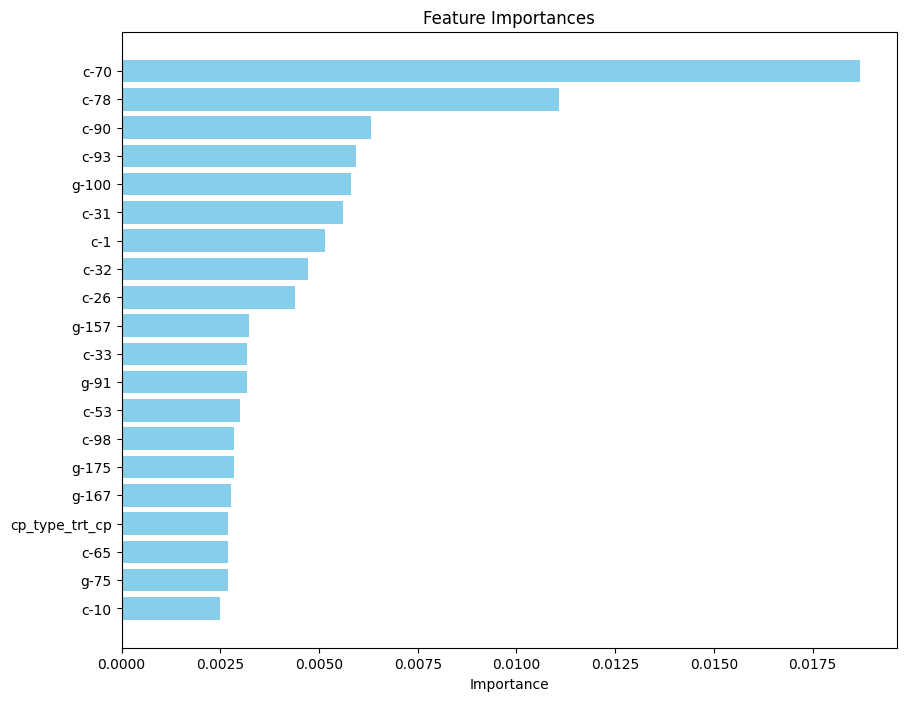

In [75]:
import matplotlib.pyplot as plt

# Initialize an array of zeros with the same length as the feature names
feature_importances = np.zeros(len(feature_columns))

# Loop over each fitted estimator/model
# Loop over each fitted estimator/model
for estimator in model.estimators_:
    # Print shapes
    print("feature_importances shape:", feature_importances.shape)
    print("estimator.feature_importances_ shape:", estimator.feature_importances_.shape)
    # Add the feature importances of the current estimator
    feature_importances += estimator.feature_importances_

# Average the feature importances by the number of estimators
feature_importances /= len(model.estimators_)

# Create a DataFrame for easier visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select top 20 features for plotting
top_features = feature_importances_df[:20]

plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [76]:
encoded_input = Input(shape=(16,))  # Adjust the dimensionality as needed
decoder_layer1 = autoencoder.layers[-2](encoded_input)
decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
decoder = Model(encoded_input, decoder_layer2)

# Now use the decoder to predict
y_pred_decoded = decoder.predict(y_pred)
y_pred_decoded = np.where(y_pred_decoded > 0.5, 1, 0)

# Now compute the F1 score
score = f1_score(y_test, y_pred_decoded, average='micro')
print('F1 Score:', score)

149/149 [==============================] - 0s 2ms/step
F1 Score: 0.15773552290406226
